### Import & load data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

--2022-09-29 20:16:48--  https://lazyprogrammer.me/course_files/airline_passengers.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2036 (2.0K) [text/csv]
Saving to: ‘airline_passengers.csv’

airline_passengers. 100%[===================>]   1.99K  --.-KB/s    in 0s      

2022-09-29 20:16:48 (22.9 MB/s) - ‘airline_passengers.csv’ saved [2036/2036]



In [4]:
!head airline_passengers.csv

"Month","Passengers"
"1949-01",112
"1949-02",118
"1949-03",132
"1949-04",129
"1949-05",121
"1949-06",135
"1949-07",148
"1949-08",148
"1949-09",136


frequency: MS



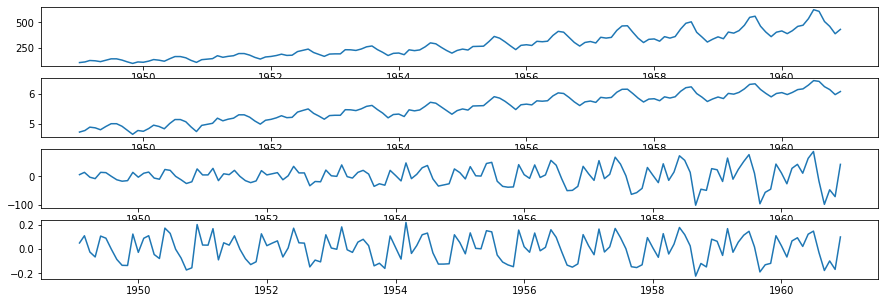

In [5]:
df = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)
print(f'frequency: {df.index.inferred_freq}\n')

fig, ax = plt.subplots(nrows=4, figsize=(15,5));
ax[0].plot(df);
ax[1].plot(df.apply(np.log));
ax[2].plot(df.diff());
ax[3].plot(df.apply(np.log).diff());

### Define plot_forecast_tf()

We fit two different models:

1.   Single-output model: predict next month based on past 12 months
2.   Multi-output model: predict next 12 months based on past 12 months

We then compare a multi-step forecast (done with the single-output model by using past predictions as input), with a multi-output forecast from the multi-output model. We try to forecast the last 12 months, based on the previous 12 months.

Note that a naive scoring for the single-output model would be on the one-step forecast, that simply predicts one month ahead. This is only interesting if we really just want to predict one step ahead with our model. It would then make no sense to compare this model with the multi-output one.

In [6]:
from sklearn.metrics._plot.roc_curve import plot_roc_curve
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List
from matplotlib.axes._axes import Axes
from numpy.lib.stride_tricks import sliding_window_view
from tensorflow.keras.models import Model, clone_model
from tensorflow.keras.layers import Dense
from keras.engine.keras_tensor import KerasTensor
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.base import clone, RegressorMixin
from sklearn.linear_model import LinearRegression

_tr_dict = {
    'id': {'direct': lambda x: x, 'inverse': lambda x: x},
    'log': {'direct': np.log, 'inverse': np.exp}
}

def plot_forecast_tf(df:pd.core.frame.DataFrame, tf_model:Model, T=12,
                     loss='mse', optimizer='adam', epochs=150, verbose=False,
                     sklearn_model:RegressorMixin=LinearRegression(), 
                     diff=False, transform='id', ax:Axes=None) -> Axes:
  
  series = df.to_numpy().reshape(-1)
  transform = _tr_dict[transform]

  # Apply transform and diff, then apply a sliding window
  series_trans = transform['direct'](series)
  if diff:
    series_diff = np.diff(series_trans)
    series_slide = sliding_window_view(series_diff, T)
  else:
    series_slide = sliding_window_view(series_trans, T)

  # Autoregression: define X and Y from data, all of lenght T.
  # Note that Y[i] = X[i+T]. They must not overlap!
  X = series_slide[:-T]
  Y = series_slide[T:]

  # We keep the last period for test.
  # To achieve complete separation of train and test, we need to remove the last
  # T sliding windows from the train set, since they all have data in common
  # with the test set.
  X_train, X_test, Y_train, Y_test = X[:-T], X[-1:], Y[:-T], Y[-1:]
  y_train, y_test = Y_train[:,0], Y_test[:, 0] # y for the single-output model

  # Reshape X_train
  X = X.reshape(-1,T,1)

  # Single-output tf model: add Dense(1)
  model_s = clone_model(tf_model)
  model_s = Model(model_s.input, Dense(1)(model_s.output))
  model_s.compile(loss=loss, optimizer=optimizer)
  r_s = model_s.fit(X_train, y_train, epochs=epochs, verbose=verbose)
  # Multi-step forecast
  X_s = X_test
  Y_s = []
  for t in range(T):
    y_s = model_s.predict(X_s)[0]
    Y_s.append(y_s)
    X_s = np.roll(X_s, -1)
    X_s[0,-1] = y_s
  Y_s = np.array(Y_s).T.reshape(-1)

  # Multi-output tf model: add Dense(T)
  model_m = clone_model(tf_model)
  model_m = Model(model_m.input, Dense(T)(model_m.output))
  model_m.compile(loss=loss, optimizer=optimizer)
  r_m = model_m.fit(X_train, Y_train, epochs=epochs, verbose=verbose)
  # Multi-output forecast
  Y_m = model_m.predict(X_test).reshape(-1)

  # Single-output sklearn model for comparison
  model2_s = clone(sklearn_model)
  model2_s.fit(X_train, y_train)
  # Multi-step forecast with sklearn model
  X2_s = X_test
  Y2_s = []
  for t in range(T):
    y2_s = model2_s.predict(X2_s)[0]
    Y2_s.append(y2_s)
    X2_s = np.roll(X2_s, -1)
    X2_s[0,-1] = y2_s
  Y2_s = np.array(Y2_s).T.reshape(-1)
  
  # Multi-output model sklearn model for comparison
  model2_m = clone(sklearn_model)
  try:
    model2_m.fit(X_train, Y_train)
  except ValueError as e:
    model2_m = MultiOutputRegressor(model2_m)
    model2_m.fit(X_train, Y_train)
  # Multi-output forecast with sklearn model
  Y2_m = model2_m.predict(X_test).reshape(-1)
  
  # Test data
  Y_test = Y_test.reshape(-1)

  # Undo diff
  if diff:
    x_0 = series_trans[[len(X)+T-1]]  # last train data before differencing
    Y_s = x_0 + np.cumsum(Y_s)
    Y_m = x_0 + np.cumsum(Y_m)
    Y2_s = x_0 + np.cumsum(Y2_s)
    Y2_m = x_0 + np.cumsum(Y2_m)
    Y_test = x_0 + np.cumsum(Y_test)
  # Undo transform
  Y_s = transform['inverse'](Y_s)
  Y_m = transform['inverse'](Y_m)
  Y2_s = transform['inverse'](Y2_s)
  Y2_m = transform['inverse'](Y2_m)
  Y_test = transform['inverse'](Y_test)

  # Compare forecasts from the two models. For the single-output model, we need to 
  # calculate the metrics on the multi-step forecast.
  print(f'R2 multi-step  : {r2_score(Y_s, Y_test):.2f} ({r2_score(Y2_s, Y_test):.2f})')
  print(f'R2 multi-output: {r2_score(Y_m, Y_test):.2f} ({r2_score(Y2_m, Y_test):.2f})')
  print(f'mape multi-step  : {mean_absolute_percentage_error(Y_s, Y_test):.2f} ({mean_absolute_percentage_error(Y2_s, Y_test):.2f})')
  print(f'mape multi-output: {mean_absolute_percentage_error(Y_m, Y_test):.2f} ({mean_absolute_percentage_error(Y2_m, Y_test):.2f})')
  print()

  # Plot data and forecasts
  if not ax: fig, ax = plt.subplots(figsize=(15,5))
  N = len(series)
  start = N - 2*T  # plot last two periods only
  #ax.plot(list(range(start,N-T+1)), series[start:N-T+1], label='train');
  #ax.plot(list(range(start+T,N)), Y_test, label='test');
  ax.plot(list(range(start,N)), series[start:], label='data')
  ax.plot(list(range(start+T,N)), Y_s, label='multi-step')
  ax.plot(list(range(start+T,N)), Y_m, label='multi-output')
  ax.axvline(x=N-T, color='black', ls='--', lw=.5)
  ax.legend()
  return ax

### Simple RNN, use only last hidden value


R2 multi-step  : -3601507.55 (0.92)
R2 multi-output: -200376.90 (0.95)
mape multi-step  : 29.79 (0.03)
mape multi-output: 31.44 (0.03)

R2 multi-step  : -325.26 (0.91)
R2 multi-output: -689.88 (0.93)
mape multi-step  : 0.81 (0.04)
mape multi-output: 0.84 (0.03)

R2 multi-step  : -341.52 (0.95)
R2 multi-output: -369.30 (0.95)
mape multi-step  : 0.17 (0.03)
mape multi-output: 0.20 (0.03)

R2 multi-step  : 0.94 (0.93)
R2 multi-output: 0.89 (0.92)
mape multi-step  : 0.03 (0.03)
mape multi-output: 0.05 (0.03)



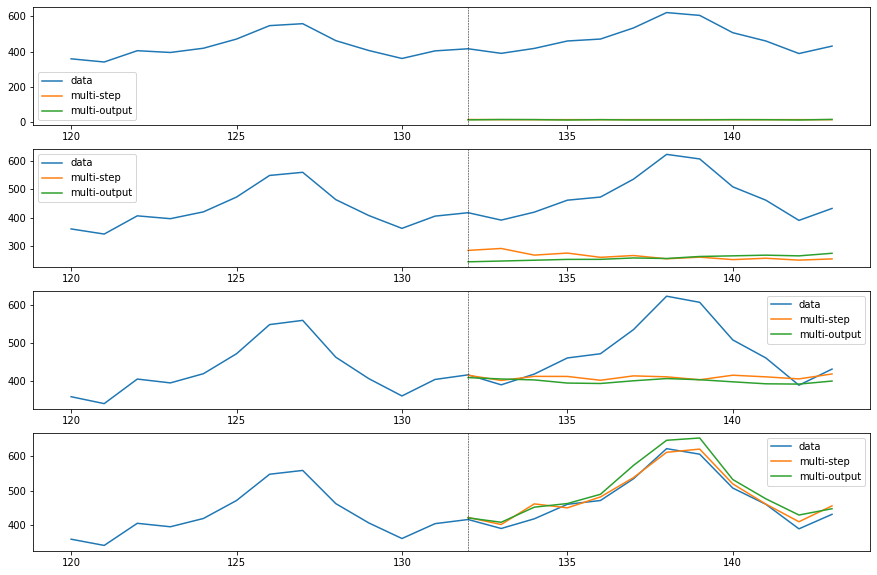

In [25]:
from tensorflow.keras.layers import Input, SimpleRNN

# We define the model up to the MaxPooling. The Dense layer is added later,
# so that we can define both a single-output and multi-output model.
T = 12
i = Input(shape=(T, 1))  # 12x1
x = SimpleRNN(24)(i)  # 24
model = Model(i, x)

# Try with and without diff and log. Compare performance against linear regression.
fig, ax = plt.subplots(4, figsize=(15,10))
plot_forecast_tf(df, model, T, ax=ax[0]);  # poor results without diff and log
plot_forecast_tf(df, model, T, ax=ax[1], transform='log');  # poor results without diff
plot_forecast_tf(df, model, T, ax=ax[2], diff=True);  # poor results without log
plot_forecast_tf(df, model, T, ax=ax[3], transform='log', diff=True);  # only decent model

### Simple RNN, use full hidden sequence


R2 multi-step  : -4668664.21 (0.92)
R2 multi-output: -151513.95 (0.95)
mape multi-step  : 36.04 (0.03)
mape multi-output: 31.26 (0.03)

R2 multi-step  : -209.60 (0.91)
R2 multi-output: -377.07 (0.93)
mape multi-step  : 0.58 (0.04)
mape multi-output: 0.83 (0.03)

R2 multi-step  : -162.16 (0.95)
R2 multi-output: -107.23 (0.95)
mape multi-step  : 0.15 (0.03)
mape multi-output: 0.16 (0.03)

R2 multi-step  : 0.83 (0.93)
R2 multi-output: 0.89 (0.92)
mape multi-step  : 0.05 (0.03)
mape multi-output: 0.04 (0.03)



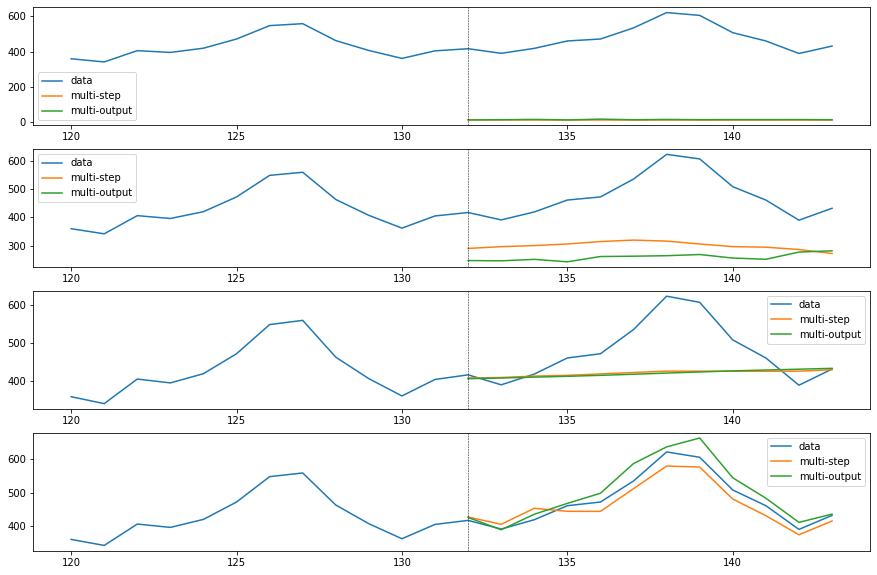

In [24]:
from tensorflow.keras.layers import Input, SimpleRNN, GlobalMaxPooling1D

# We define the model up to the MaxPooling. The Dense layer is added later,
# so that we can define both a single-output and multi-output model.
T = 12
i = Input(shape=(T, 1))  # 12x1
x = SimpleRNN(24, return_sequences=True)(i)  # 12x24
x = GlobalMaxPooling1D()(x)    # 24
model = Model(i, x)

# Try with and without diff and log. Compare performance against linear regression.
fig, ax = plt.subplots(4, figsize=(15,10))
plot_forecast_tf(df, model, T, ax=ax[0]);  # poor results without diff and log
plot_forecast_tf(df, model, T, ax=ax[1], transform='log');  # poor results without diff
plot_forecast_tf(df, model, T, ax=ax[2], diff=True);  # poor results without log
plot_forecast_tf(df, model, T, ax=ax[3], transform='log', diff=True);  # only decent model

### GRU, use only last hidden value

R2 multi-step  : -579370.00 (0.92)
R2 multi-output: -117789.61 (0.95)
mape multi-step  : 48.76 (0.03)
mape multi-output: 41.83 (0.03)

R2 multi-step  : -1283.44 (0.91)
R2 multi-output: -533.71 (0.93)
mape multi-step  : 0.92 (0.04)
mape multi-output: 0.84 (0.03)

R2 multi-step  : -13.32 (0.95)
R2 multi-output: -322.05 (0.95)
mape multi-step  : 0.11 (0.03)
mape multi-output: 0.17 (0.03)

R2 multi-step  : 0.87 (0.93)
R2 multi-output: 0.74 (0.92)
mape multi-step  : 0.04 (0.03)
mape multi-output: 0.07 (0.03)



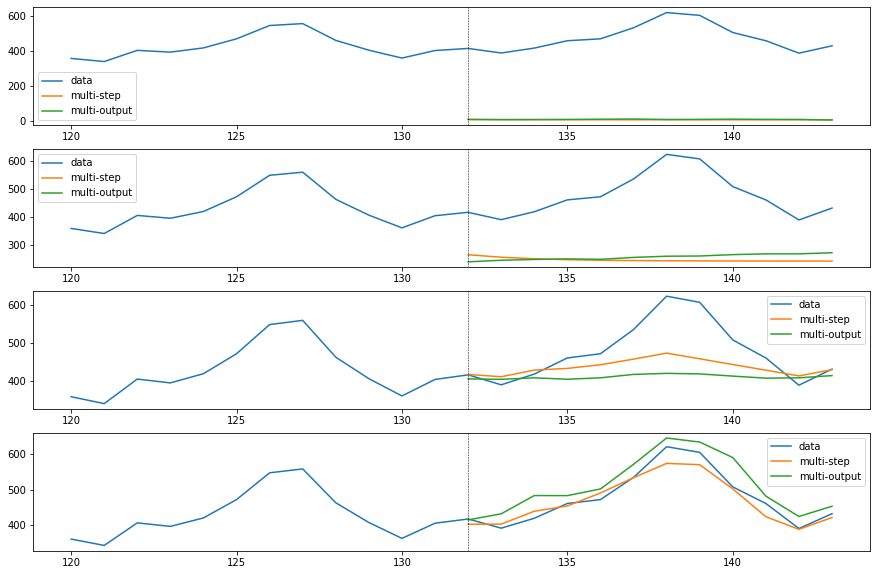

In [18]:
from tensorflow.keras.layers import Input, GRU

# We define the model up to the MaxPooling. The Dense layer is added later,
# so that we can define both a single-output and multi-output model.
T = 12
i = Input(shape=(T, 1))  # 12x1
x = GRU(24)(i)  # 24
model = Model(i, x)

# Try with and without diff and log. Compare performance against linear regression.
fig, ax = plt.subplots(4, figsize=(15,10))
plot_forecast_tf(df, model, T, ax=ax[0]);  # poor results without diff and log
plot_forecast_tf(df, model, T, ax=ax[1], transform='log');  # poor results without diff
plot_forecast_tf(df, model, T, ax=ax[2], diff=True);  # poor results without log
plot_forecast_tf(df, model, T, ax=ax[3], transform='log', diff=True);  # only decent model

### GRU, use full hidden sequence

R2 multi-step  : -2031912.29 (0.92)
R2 multi-output: -244098.52 (0.95)
mape multi-step  : 49.96 (0.03)
mape multi-output: 32.23 (0.03)

R2 multi-step  : -18955.00 (0.91)
R2 multi-output: -499.32 (0.93)
mape multi-step  : 0.86 (0.04)
mape multi-output: 0.75 (0.03)

R2 multi-step  : -9.95 (0.95)
R2 multi-output: -319.36 (0.95)
mape multi-step  : 0.11 (0.03)
mape multi-output: 0.15 (0.03)

R2 multi-step  : 0.92 (0.93)
R2 multi-output: 0.50 (0.92)
mape multi-step  : 0.03 (0.03)
mape multi-output: 0.09 (0.03)



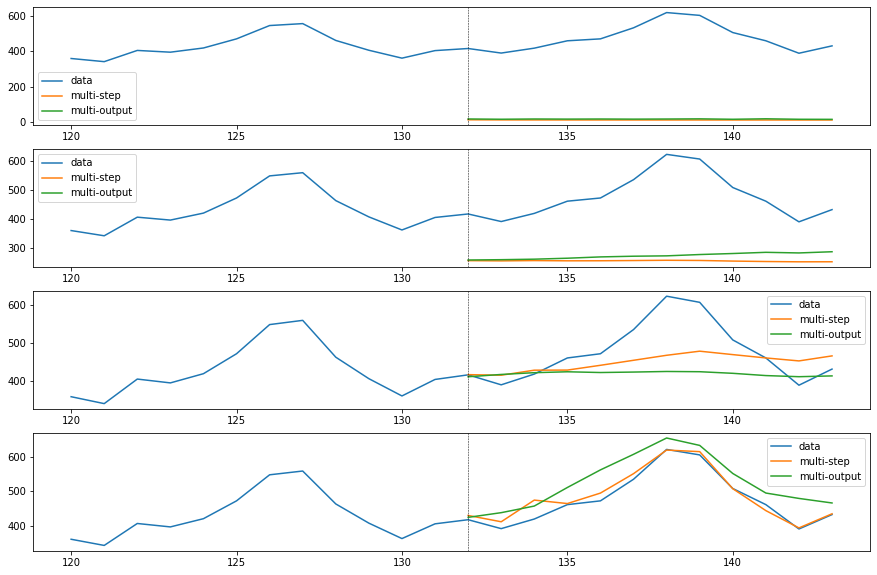

In [20]:
from tensorflow.keras.layers import Input, GRU, GlobalMaxPooling1D

# We define the model up to the MaxPooling. The Dense layer is added later,
# so that we can define both a single-output and multi-output model.
T = 12
i = Input(shape=(T, 1))  # 12x1
x = GRU(24, return_sequences=True)(i)  # 12x24
x = GlobalMaxPooling1D()(x)  # 24
model = Model(i, x)

# Try with and without diff and log. Compare performance against linear regression.
fig, ax = plt.subplots(4, figsize=(15,10))
plot_forecast_tf(df, model, T, ax=ax[0]);  # poor results without diff and log
plot_forecast_tf(df, model, T, ax=ax[1], transform='log');  # poor results without diff
plot_forecast_tf(df, model, T, ax=ax[2], diff=True);  # poor results without log
plot_forecast_tf(df, model, T, ax=ax[3], transform='log', diff=True);  # only decent model

### LSTM, use only last hidden value

R2 multi-step  : -793315.34 (0.92)
R2 multi-output: -318965.03 (0.95)
mape multi-step  : 83.63 (0.03)
mape multi-output: 48.50 (0.03)

R2 multi-step  : -391.81 (0.91)
R2 multi-output: -491.51 (0.93)
mape multi-step  : 0.74 (0.04)
mape multi-output: 0.83 (0.03)

R2 multi-step  : -24.39 (0.95)
R2 multi-output: -127.77 (0.95)
mape multi-step  : 0.12 (0.03)
mape multi-output: 0.15 (0.03)

R2 multi-step  : 0.91 (0.93)
R2 multi-output: 0.72 (0.92)
mape multi-step  : 0.04 (0.03)
mape multi-output: 0.08 (0.03)



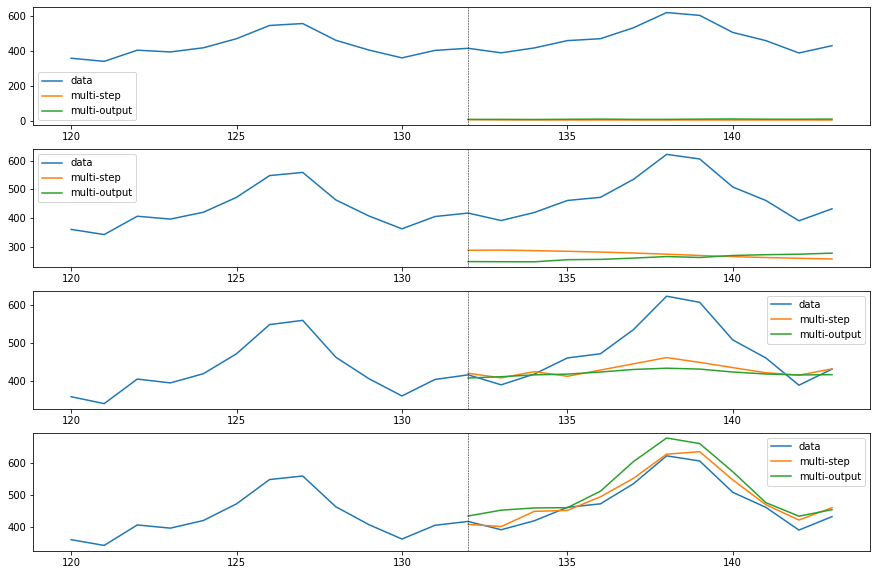

In [22]:
from tensorflow.keras.layers import Input, LSTM

# We define the model up to the MaxPooling. The Dense layer is added later,
# so that we can define both a single-output and multi-output model.
T = 12
i = Input(shape=(T, 1))  # 12x1
x = LSTM(24)(i)  # 24
model = Model(i, x)

# Try with and without diff and log. Compare performance against linear regression.
fig, ax = plt.subplots(4, figsize=(15,10))
plot_forecast_tf(df, model, T, ax=ax[0]);  # poor results without diff and log
plot_forecast_tf(df, model, T, ax=ax[1], transform='log');  # poor results without diff
plot_forecast_tf(df, model, T, ax=ax[2], diff=True);  # poor results without log
plot_forecast_tf(df, model, T, ax=ax[3], transform='log', diff=True);  # only decent model

### LSTM, use full hidden sequence

R2 multi-step  : -2930564.90 (0.92)
R2 multi-output: -289278.38 (0.95)
mape multi-step  : 47.77 (0.03)
mape multi-output: 43.23 (0.03)

R2 multi-step  : -2803.97 (0.91)
R2 multi-output: -408.04 (0.93)
mape multi-step  : 0.77 (0.04)
mape multi-output: 0.72 (0.03)

R2 multi-step  : -29.03 (0.95)
R2 multi-output: -333.09 (0.95)
mape multi-step  : 0.12 (0.03)
mape multi-output: 0.15 (0.03)

R2 multi-step  : 0.80 (0.93)
R2 multi-output: 0.65 (0.92)
mape multi-step  : 0.06 (0.03)
mape multi-output: 0.07 (0.03)



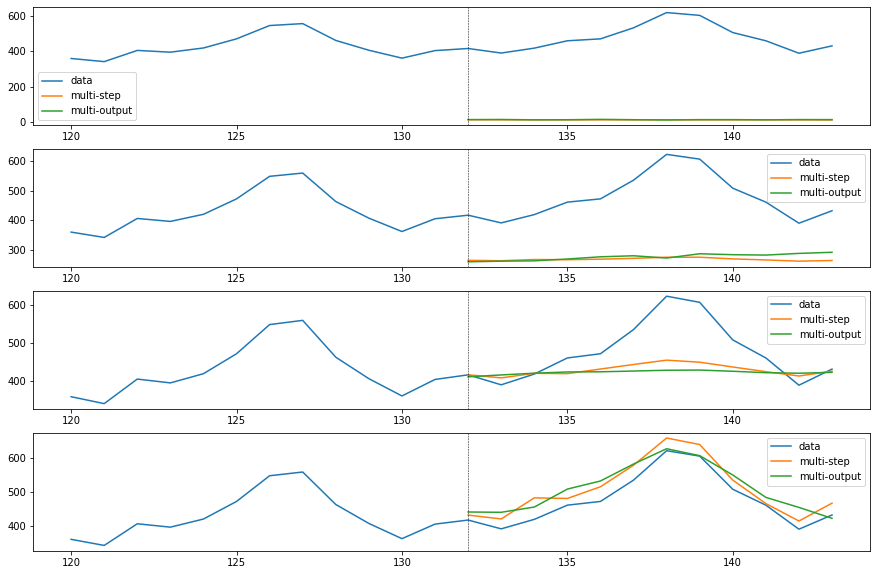

In [23]:
from tensorflow.keras.layers import Input, LSTM, GlobalMaxPooling1D

# We define the model up to the MaxPooling. The Dense layer is added later,
# so that we can define both a single-output and multi-output model.
T = 12
i = Input(shape=(T, 1))  # 12x1
x = LSTM(24, return_sequences=True)(i)  # 24
x = GlobalMaxPooling1D()(x)  # 24
model = Model(i, x)

# Try with and without diff and log. Compare performance against linear regression.
fig, ax = plt.subplots(4, figsize=(15,10))
plot_forecast_tf(df, model, T, ax=ax[0]);  # poor results without diff and log
plot_forecast_tf(df, model, T, ax=ax[1], transform='log');  # poor results without diff
plot_forecast_tf(df, model, T, ax=ax[2], diff=True);  # poor results without log
plot_forecast_tf(df, model, T, ax=ax[3], transform='log', diff=True);  # only decent model